In [1]:
import numpy as np
from grid_methods.pseudospectral_grids.gauss_legendre_lobatto import (
    GaussLegendreLobatto,
    Linear_map,
)
from matplotlib import pyplot as plt
from scipy.special import erf

In [2]:
def Verfgau(d, Z=1.0, mu=1.0):
    """
    Args:
    d: d=|r-A| where A is the nucleus position
    Z: nuclear charge
    mu: screening parameter
    """
    c = 0.923 + 1.568 * mu
    alpha = 0.2411 + 1.405 * mu
    long_range = erf(mu * Z * d) / (Z * d)
    return -(Z**2) * (
        c * np.exp(-(alpha**2) * Z**2 * d**2) + long_range
    )
def V_HO(r, z, omega=1.0):
    return 0.5*omega**2*(r**2+z**2)

In [3]:
"""
Define grid paramters
"""
N_rho = 30
rho_min = 0
rho_max = 10.0

N_z = 2 * N_rho
z_min = -10.0
z_max = 10.0

Setup Gauss-Legendre-Lobatto grid.
The inner grid points $x_1,\cdots, x_{N-1} \in [-1,1]$ are the zeros of the derivative of the N-th order Legendre 
polynomial $P^\prime_N(x)$, while the end points are $x_0=-1, x_N=1$. Additionally, we map the points 
$\rho(x): [-1,1] \rightarrow [0, \rho_{max}]$, $z(x): [-1,1] \rightarrow [z_{min}, z_{max}]$.

In [4]:
GLL_rho = GaussLegendreLobatto(N_rho, Linear_map(rho_min, rho_max))
rho = GLL_rho.r[1:-1]

GLL_z = GaussLegendreLobatto(N_z, Linear_map(z_min, z_max))
z = GLL_z.r[1:-1]

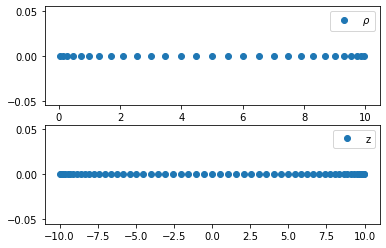

In [5]:
"""
Plot the mapped grid points
"""
plt.figure()
plt.subplot(211)
plt.plot(rho, np.zeros(N_rho-1), 'o', label=r'$\rho$')
plt.legend()
plt.subplot(212)
plt.plot(z, np.zeros(N_z-1), 'o', label='z')
plt.legend()
plt.show()

In [6]:
D2_rho = GLL_rho.D2[1:-1, 1:-1]
D2_z = GLL_z.D2[1:-1, 1:-1]

In [7]:
"""
Modify the differentiation matrix to account for the Neumann boundary condition
    dpsi(rho,z)/drho|rho=0 = 0
"""
D1 = GLL_rho.D1
G = np.zeros((N_rho + 1, N_rho - 1))
G[1:N_rho, :] = np.eye(N_rho - 1)
for j in range(1, N_rho):
    G[0, j - 1] = -1 / D1[0, 0] * D1[0, j]
D1_neumann = np.dot(D1, G)
D2_rho_0 = np.dot(D1, D1_neumann)[1:N_rho,:]
D1_neumann = D1_neumann[1:N_rho, :]

In [8]:
rho_inv_D1_rho_0 = D1_neumann #For m=0 we have Neumann conditions
rho_inv_D1_rho = GLL_rho.D1[1:-1, 1:-1] #For m!=0 we have Dirichlet conditions

for i in range(rho_inv_D1_rho.shape[0]):
    for j in range(rho_inv_D1_rho.shape[1]):
        rho_inv_D1_rho_0[i, j] /= rho[i]
        rho_inv_D1_rho[i, j] /= rho[i]

In [9]:
I_rho = np.eye(N_rho - 1)
I_z = np.eye(N_z - 1)

#Setup the kinetic energy matrix for m=0
T0 = -0.5 * (
    np.kron(D2_rho_0, I_z)
    + np.kron(I_rho, D2_z)
    + np.kron(rho_inv_D1_rho_0, I_z)
)

#Setup the kinetic energy matrix for m=1
T1 = -0.5 * (
    np.kron(D2_rho, I_z)
    + np.kron(I_rho, D2_z)
    + np.kron(np.diag(-(1**2) / rho**2), I_z)
    + np.kron(rho_inv_D1_rho, I_z)
)

In [10]:
rho_grid, z_grid = np.meshgrid(rho, z, indexing='ij')
r = np.sqrt(rho_grid**2 + z_grid**2)
V = 0.5 * (rho_grid**2 + z_grid**2)

In [11]:
H0 = T0+np.diag(V.ravel())
H1 = T1+np.diag(V.ravel())

eps0, C0 = np.linalg.eig(H0)
eps1, C1 = np.linalg.eig(H1)

In [12]:
idx0 = np.argsort(eps0)
eps0 = eps0[idx0]
C0 = C0[:, idx0]
print(eps0[0:3])

idx1 = np.argsort(eps1)
eps1 = eps1[idx1]
C1 = C1[:, idx1]
print(eps1[0:3])

[1.5 2.5 3.5]
[2.5 3.5 4.5]
